In [1]:
import pandas as pd
import numpy as np
import torch
import timesead
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def read_with_time_index(file_path, time_col):
    df = pd.read_csv(file_path, delimiter=';', skiprows=1, low_memory=False) #skiprows a adapter selon la position des colonnes du fichier
    
    # Vérifier si la colonne de dates est présente dans le DataFrame
    if time_col in df.columns:
        df[time_col] = pd.to_numeric(df[time_col])
        df.set_index(time_col, inplace=True)
            
        if not df.index.is_monotonic_increasing:
            print("L'index n'est pas trié. Tri en cours...")
            df.sort_index(inplace=True)
            print("L'index a été trié avec succès.")
    else:
        print(f"La colonne '{time_col}' n'a pas été trouvée. L'index par défaut sera utilisé.")
    
    return df

In [3]:
def clean_empty_columns(df):
    empty_columns = df.columns[df.isna().all()]
    print(f"Colonnes totalement vides avant suppression : {list(empty_columns)}")

    df_cleaned = df.dropna(axis=1, how="all")
    return df_cleaned

In [4]:
file_path = "C:/Users/pellerinc/Downloads/occupancy+detection/datatest2.txt"
APLfile_path = "C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/i.O/WLTC_1.csv"
#df1 = read_with_time_index(file_path,'date')
df2 = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/i.O/WLTC_1.csv", 's') # In Ordnung
dftest = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/i.O/WLTC_8.csv", 's') # In Ordnung
df3 = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/n.i.O/WLTC_118.csv", 's') # Nicht in Ordnung
df4 = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/n.i.O/WLTC_119.csv", 's') # Nicht in Ordnung
df5 = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/n.i.O/WLTC_120.csv", 's') # Nicht in Ordnung
df6 = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/n.i.O/WLTC_121.csv", 's') # Nicht in Ordnung
df7 = read_with_time_index("C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/n.i.O/WLTC_122.csv", 's') # Nicht in Ordnung

In [5]:
#Pour voir quelles sont les colonnes vides dans tous les fichiers In Ordnung
folder_path = "C:/Users/pellerinc/TimeSeAD-master/Daten_von_APL/Export/i.O"
file_paths = glob.glob(os.path.join(folder_path, "WLTC_*.csv"))  # Trouver tous les fichiers WLTC_i.csv

empty_columns_per_file = {}

for file_path in file_paths:
    try:
        df = pd.read_csv(file_path, delimiter=';', skiprows=1, low_memory=False)
        empty_columns = df.columns[df.isna().all()]  # Colonnes totalement vides
        empty_columns_per_file[os.path.basename(file_path)] = list(empty_columns)
    except Exception as e:
        empty_columns_per_file[os.path.basename(file_path)] = f"Erreur lors de la lecture : {e}"

df_empty_columns = pd.DataFrame(list(empty_columns_per_file.items()), columns=["Fichier", "Colonnes Vides"])

print(df_empty_columns)

          Fichier                              Colonnes Vides
0      WLTC_1.csv                                          []
1     WLTC_10.csv                               [°CRK, hPa.2]
2    WLTC_100.csv  [unknown, unknown.1, unknown.2, unknown.3]
3    WLTC_101.csv  [unknown, unknown.1, unknown.2, unknown.3]
4     WLTC_11.csv                               [°CRK, hPa.2]
..            ...                                         ...
96    WLTC_95.csv                  [°CRK, ms, µs, °.2, hPa.2]
97    WLTC_96.csv                       [°CRK, ms, µs, hPa.2]
98    WLTC_97.csv  [unknown, unknown.1, unknown.2, unknown.3]
99    WLTC_98.csv  [unknown, unknown.1, unknown.2, unknown.3]
100   WLTC_99.csv  [unknown, unknown.1, unknown.2, unknown.3]

[101 rows x 2 columns]


In [6]:
df5.columns

Index(['rpm', 'Nm', '%', '°C', '°C.1', 'hPa', '%.1', 'mm', '°', '°.1', '-',
       '-.1', 'mbar', 'hPa.1', 'kg/h', 'unknown', 'unknown.1', 'unknown.2',
       '°CRK', '°CRK.1', '°.2', '°CRK.2', '-.2', '°.3', '°.4', '°C.2', '°C.3',
       '°C.4', '%.2', 'mbar.1', 'unknown.3', '°C.5', 'mbar.2', 'bar', 'mbar.3',
       '°C.6', '°C.7', '°C.8', '°C.9', '°C.10', '°C.11', '°C.12', 'g/h', '1/s',
       'g/s', 'mg/s', 'ppm', 'ppm.1', 'ppm.2'],
      dtype='object')

In [7]:
df3.head()

,rpm,Nm,%,°C,°C.1,hPa,%.1,mm,°,°.1,...,°C.10,°C.11,°C.12,g/h,1/s,g/s,mg/s,ppm,ppm.1,ppm.2
s,,,,,,,,,,,,,,,,,,,,,
0.0,0,0.0,0.0,36.1,26.8,963.875,3.52,0.048,120.0,122.5,...,18.6,81.4,88.2,0.0,0.0,0.0,0.0,5676.6,12.4,12.8
0.1,0,0.0,0.0,36.1,26.8,963.875,3.52,0.048,120.0,122.5,...,18.6,81.4,88.2,0.0,0.0,0.0,0.0,5676.6,12.4,12.8
0.2,0,0.0,0.0,36.1,26.8,963.875,3.52,0.048,120.0,122.5,...,18.6,81.4,88.2,0.0,0.0,0.0,0.0,5676.6,12.4,12.8
0.3,0,0.0,0.0,36.1,26.8,963.875,3.52,0.048,120.0,122.5,...,18.6,81.4,88.2,0.0,0.0,0.0,0.0,5676.6,12.4,12.8
0.4,0,0.0,0.0,36.1,26.8,963.875,3.52,0.048,120.0,122.5,...,18.6,81.4,88.1,0.0,0.0,0.0,0.0,5676.6,12.4,12.8


In [8]:
df3.shape

(18491, 49)

In [9]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18491 entries, 0.0 to 1849.0
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rpm     18491 non-null  int64  
 1   Nm      18491 non-null  float64
 2   %       18491 non-null  float64
 3   °C      18491 non-null  float64
 4   °C.1    18491 non-null  float64
 5   hPa     18491 non-null  float64
 6   %.1     18491 non-null  float64
 7   mm      18491 non-null  float64
 8   °       18491 non-null  float64
 9   °.1     18491 non-null  float64
 10  -       18491 non-null  int64  
 11  -.1     18491 non-null  float64
 12  mbar    18491 non-null  int64  
 13  hPa.1   18491 non-null  float64
 14  kg/h    18491 non-null  float64
 15  °CRK    0 non-null      float64
 16  ms      0 non-null      float64
 17  µs      0 non-null      float64
 18  °CRK.1  18491 non-null  float64
 19  °CRK.2  18491 non-null  float64
 20  °.2     18491 non-null  float64
 21  °CRK.3  18491 non-null  float64
 22  

In [10]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18491 entries, 0.0 to 1849.0
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rpm     18491 non-null  int64  
 1   Nm      18491 non-null  float64
 2   %       18491 non-null  float64
 3   °C      18491 non-null  float64
 4   °C.1    18491 non-null  float64
 5   hPa     18491 non-null  float64
 6   %.1     18491 non-null  float64
 7   mm      18491 non-null  float64
 8   °       18491 non-null  float64
 9   °.1     18491 non-null  float64
 10  -       18491 non-null  int64  
 11  -.1     18491 non-null  float64
 12  mbar    18491 non-null  int64  
 13  hPa.1   18491 non-null  float64
 14  kg/h    18491 non-null  float64
 15  °CRK    0 non-null      float64
 16  ms      0 non-null      float64
 17  µs      0 non-null      float64
 18  °CRK.1  18491 non-null  float64
 19  °CRK.2  18491 non-null  float64
 20  °.2     18491 non-null  float64
 21  °CRK.3  18491 non-null  float64
 22  

In [11]:
df3 = clean_empty_columns(df3)

Colonnes totalement vides avant suppression : ['°CRK', 'ms', 'µs', 'hPa.2']


In [12]:
df3.shape

(18491, 45)

In [13]:
df2.describe()

,rpm,Nm,%,°C,°C.1,hPa,%.1,mm,°,°.1,...,°C.10,°C.11,°C.12,g/h,1/s,g/s,mg/s,ppm,ppm.1,ppm.2
count,18483.000000,18483.000000,18483.000000,18483.000000,18483.000000,18483.000000,18483.000000,18483.000000,18483.000000,18483.000000,...,18483.000000,18483.000000,18483.000000,18483.000000,1.844300e+04,18447.000000,18458.000000,18483.000000,18483.000000,18483.000000
mean,1186.426554,50.118742,26.591886,29.528291,39.987150,978.560285,26.648958,2.588024,102.491170,91.422697,...,19.917459,82.830336,93.052199,1.351581,1.027041e+10,0.140973,11.238453,4964.396169,959.648802,977.053141
std,603.265513,65.456734,26.705313,1.909216,3.958245,81.982254,26.711601,2.933947,17.007954,22.417332,...,1.434957,2.776340,3.088117,1.485840,3.584088e+10,0.379142,12.444923,6928.606700,1070.249004,1087.232159
min,0.000000,-29.500000,0.000000,24.900000,33.400000,823.125000,0.000000,0.000000,70.000000,62.700000,...,17.000000,77.900000,83.000000,0.000000,0.000000e+00,0.000000,0.000000,47.100000,0.400000,1.100000
25%,1076.000000,-6.200000,0.000000,28.100000,37.200000,916.250000,0.910000,0.001000,85.100000,67.900000,...,18.800000,80.600000,91.500000,0.000000,0.000000e+00,0.000000,0.000000,745.500000,26.000000,28.900000
50%,1253.000000,20.800000,27.880859,30.100000,38.700000,966.625000,18.440000,0.816000,104.300000,86.600000,...,20.000000,83.400000,93.900000,1.010000,4.638198e+08,0.052982,8.404144,3495.400000,528.600000,531.600000
75%,1505.000000,103.300000,50.537109,31.000000,41.900000,1000.125000,47.945000,5.469000,118.900000,111.100000,...,21.000000,85.100000,95.300000,2.210000,3.571471e+09,0.138849,19.005437,5417.800000,1829.400000,1870.600000
max,2829.000000,261.400000,90.991211,32.800000,57.900000,1501.750000,113.320000,8.460000,120.900000,123.100000,...,22.800000,88.800000,97.900000,9.360000,7.545805e+11,5.348646,109.183306,48634.900000,3519.200000,3588.300000


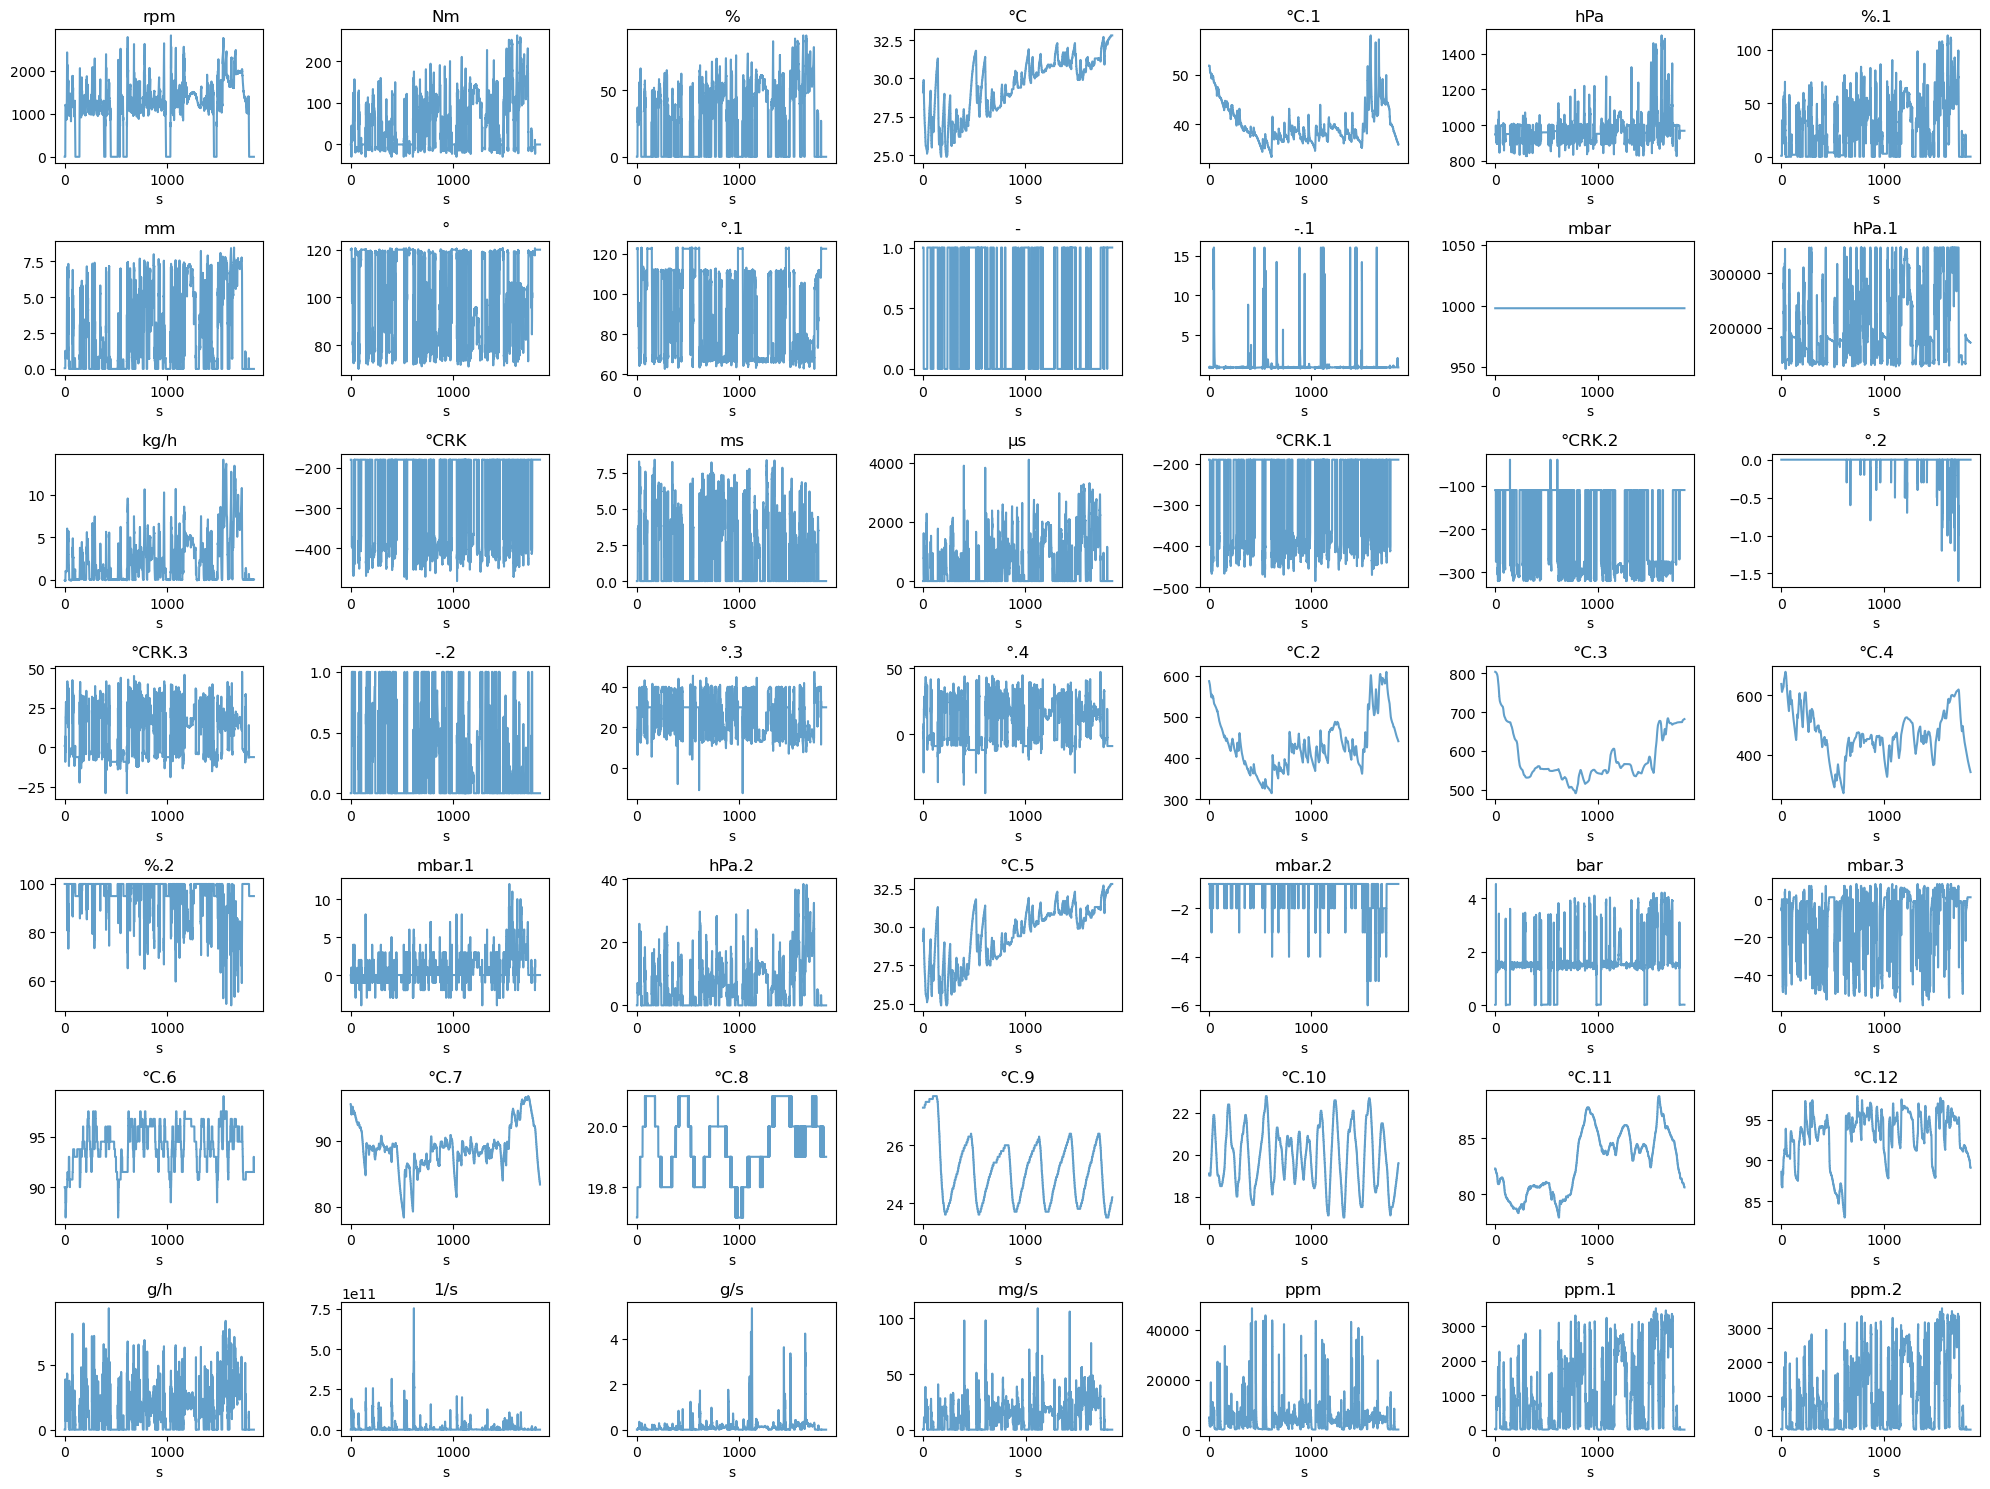

In [14]:
#Visualisation de l'ensemble des features
fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df2.columns):
    df2[col].plot(ax=axes[i], title=col, alpha=0.7)

plt.tight_layout()
plt.show()

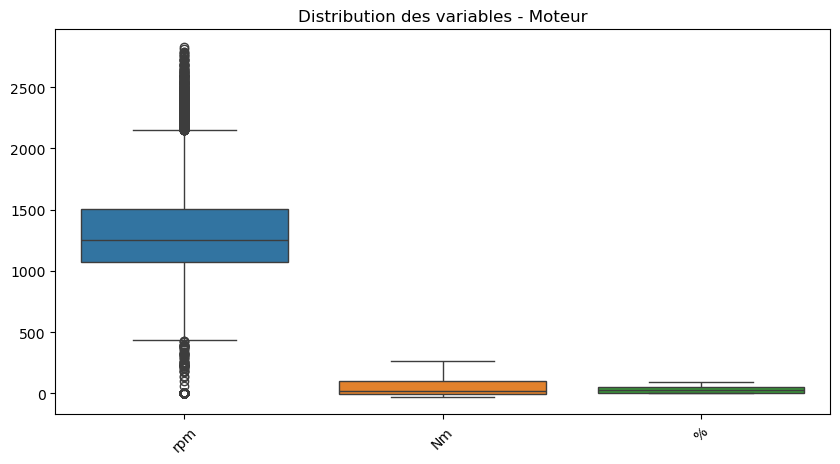

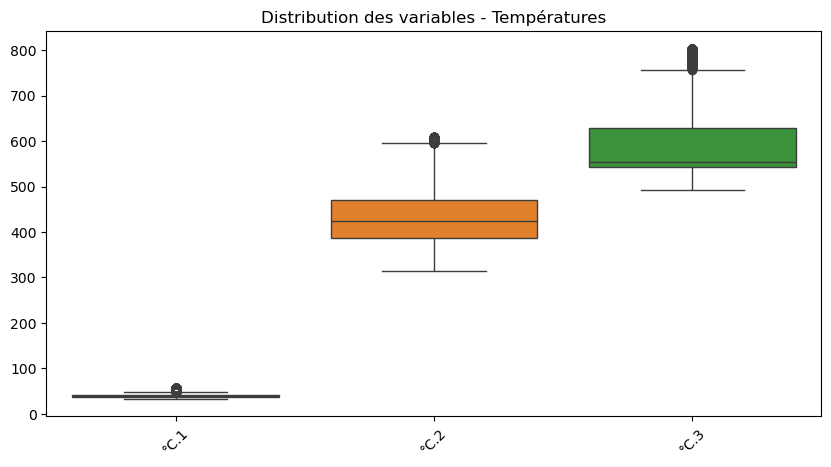

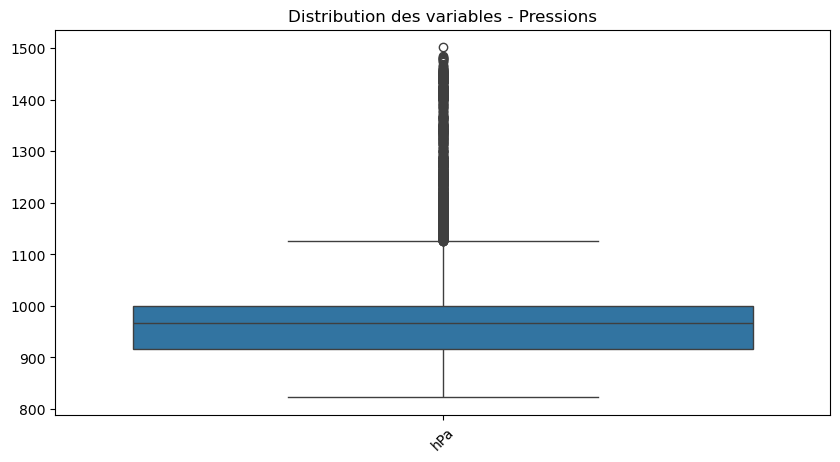

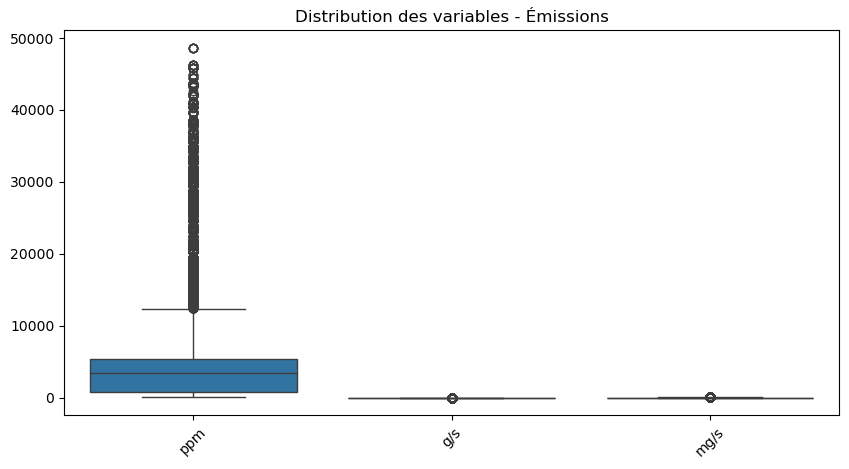

In [15]:
# Diviser les colonnes en groupes logiques
groups = {
    "Moteur": ["rpm", "Nm", "%"],
    "Températures": ["°C.1", "°C.2", "°C.3"],
    "Pressions": ["hPa"],
    "Émissions": ["ppm", "g/s", "mg/s"],
}

for category, cols in groups.items():
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df2[cols])
    plt.xticks(rotation=45)
    plt.title(f"Distribution des variables - {category}")
    plt.show()

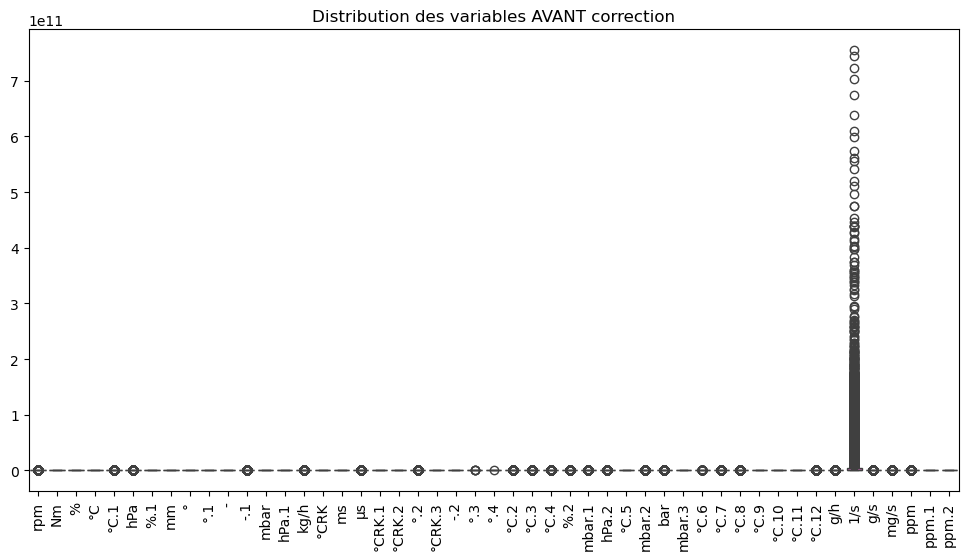

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df2)
plt.xticks(rotation=90)
plt.title("Distribution des variables AVANT correction")
plt.show()

In [17]:
MODEL_MAP = {
    "Reconstruction": {
        "lstm_ae": "from timesead.models.reconstruction.lstm_ae import LSTMAEAnomalyDetector",
        "tcn_ae": "from timesead.models.reconstruction.tcn_ae import TCNAEAnomalyDetector",
        "usad": "from timesead.models.reconstruction.usad import USADAnomalyDetector",
        "mscred": "from timesead.models.reconstruction.mscred import MSCREDAnomalyDetector",
        "genad": "from timesead.models.reconstruction.genad import GENADDetector",
        "anom_trans": "from timesead.models.reconstruction.anom_trans import AnomalyTransformer",
        "stgat_mad": "from timesead.models.reconstruction.stgat_mad import STGATMAD",
    },
    "prediction": {
        "gdn": "from timesead.models.prediction.gdn import GDN",
        "lstm_prediction": "from timesead.models.prediction.lstm_prediction import LSTMPredictionAnomalyDetector",
        "tcn_prediction": "from timesead.models.prediction.tcn_prediction import TCNPredictionAnomalyDetector",
    },
    "generative-GAN": {
        "madgan": "from timesead.models.generative.madgan import MADGANAnomalyDetector",
        "tadgan": "from timesead.models.generative.tadgan import TADGANAnomalyDetector",
        "beatgan": "from timesead.models.generative.beatgan import BeatGAN",
        "lstm_vae_gan": "from timesead.models.generative.lstm_vae_gan import LSTM_VAE_GAN",
    },
    "generative-VAE": {
        "lstm_vae": "from timesead.models.generative.lstm_vae import LSTMVAE",
        "gmm_gru_vae": "from timesead.models.generative.gmm_gru_vae import GMMGRUVAE",
        "sis_vae": "from timesead.models.generative.sis_vae import SISVAE",
        "omni_anomaly": "from timesead.models.generative.omni_anomaly import OmniAnomaly",
        "donut": "from timesead.models.generative.donut import DonutAnomalyDetector",
    },
    "other": {
        "thoc": "from timesead.models.other.thoc import THOCAnomalyDetector",
        "mtad_gat": "from timesead.models.other.mtad_gat import MTAD_GATAnomalyDetector",
        "ncad": "from timesead.models.other.ncad import NCADAnomalyDetector",
        "lstm_ae_ocsvm": "from timesead.models.other.lstm_ae_ocsvm import LSTMAE_OCSVM",
    },
}

In [29]:
class MethodChooser:
    """
    Classe responsable de l'analyse du dataset et de la sélection automatique du modèle.
    """

    @staticmethod
    def analyze_dataset(data, labels=None):
        """Analyse le dataset pour extraire les caractéristiques principales."""
        num_samples, num_features = data.shape
        labels_available = labels is not None and len(labels) == num_samples

        # Calcul du ratio d'anomalies (si les labels existent)
        if labels_available and len(labels) > 0:
            anomaly_ratio = np.sum(labels) / len(labels)
        else:
            anomaly_ratio = 0

        # Déterminer le type d'anomalie
        anomaly_type = (
            "point" if anomaly_ratio < 0.01 else
            "contextual" if anomaly_ratio < 0.05 else
            "collective"
        ) if labels_available else "unknown"

        # Vérifier si le dataset est en temps réel (grande taille et plusieurs features)
        real_time = num_samples > 10_000 and num_features > 5

        return {
            "num_samples": num_samples,
            "num_features": num_features,
            "labels_available": labels_available,
            "anomaly_type": anomaly_type,
            "real_time": real_time
        }

    @staticmethod
    def select_best_model(data, labels_available=False, anomaly_type="point", real_time=False, forced_model=None):
        """Sélectionne le modèle optimal en fonction des caractéristiques du dataset."""
        if forced_model:
            return forced_model  # Priorité au modèle forcé
        num_samples, num_features = data.shape

        # Modèles selon le type d'anomalie
        models = {
            "point": "lstm_ae" if not labels_available else "gdn",
            "contextual": "anom_trans" if not labels_available else "mtad_gat",
            "collective": "mscred" if not labels_available else "thoc",
        }

        # Conditions spécifiques pour les modèles
        if real_time:
            selected_model = "gdn" if labels_available else "tcn_prediction"
        elif num_samples < 1000:
            selected_model = "donut" if labels_available else "tcn_prediction"
        elif num_samples > 10_000:
            selected_model = "anom_trans" if not labels_available else "mtad_gat"
        else:
            selected_model = anomaly_models.get(anomaly_type, "omni_anomaly" if not labels_available else "lstm_prediction")

        # Récupération du module et de la classe directement depuis MODEL_MAP
        model_import_path = None
        for category, models in MODEL_MAP.items():
            if selected_model in models:
                model_import_path = models[selected_model]
                break

        if model_import_path:
            module_path, class_name = model_import_path.replace("from ", "").split(" import ")
            module = __import__(module_path, fromlist=[class_name])
            model_class = getattr(module, class_name)
            print(f"Modèle sélectionné : {selected_model} ({class_name})")
            return model_class
        else:
            raise ValueError(f"Aucun import trouvé pour le modèle {selected_model}")


In [30]:
class UpstreamDataPreparation:
    def __init__(self, method="IQR", threshold=1.5, sensor_threshold=3, seq_length=50, scale_method="standard"):
        self.method = method
        self.threshold = threshold
        self.sensor_threshold = sensor_threshold
        self.seq_length = seq_length
        self.scale_method = scale_method
        self.scaler = None  # Scaler stocké pour réutilisation

    def detect_outliers(self, data):
        """Détecte les outliers avec IQR ou MAD."""
        if self.method == "IQR":
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            return (data < (Q1 - self.threshold * IQR)) | (data > (Q3 + self.threshold * IQR))
        elif self.method == "MAD":
            median = data.median()
            mad = (data - median).abs().median()
            return (data - median).abs() > (self.threshold * 1.4826 * mad)

    def classify_outliers(self, data, outlier_mask):
        """Classe les outliers en anomalies moteur ou erreurs capteurs."""
        data_clean = data.copy()
        anomalies_moteur = outlier_mask.sum(axis=1) >= self.sensor_threshold
        for col in data.columns:
            mask = outlier_mask[col] & ~anomalies_moteur
            data_clean.loc[mask, col] = np.nan  # Suppression des erreurs capteurs
        data_clean = data_clean.interpolate(method='time').bfill()
        return data_clean, anomalies_moteur

    def normalize_data(self, train_data, test_data=None):
        """Normalisation des données avec choix entre MinMaxScaler et StandardScaler."""
        if self.scale_method == "minmax":
            self.scaler = MinMaxScaler()
        else:
            self.scaler = StandardScaler()
        
        train_data_scaled = pd.DataFrame(self.scaler.fit_transform(train_data), 
                                         columns=train_data.columns, index=train_data.index)
        
        if test_data is not None:
            test_data_scaled = pd.DataFrame(self.scaler.transform(test_data), 
                                            columns=test_data.columns, index=test_data.index)
            return train_data_scaled, test_data_scaled
        
        return train_data_scaled
    
    def create_sequences(self, data):
        """Transforme les données en séquences temporelles adaptées à TimeSeAD."""
        data_np = data.to_numpy()
        if len(data_np) < self.seq_length:
            raise ValueError(f"Pas assez de données ({len(data_np)}) pour créer des séquences de longueur {self.seq_length}")
        sequences = np.array([data_np[i:i + self.seq_length] for i in range(len(data_np) - self.seq_length)])
        return torch.tensor(sequences, dtype=torch.float32)

    def preprocess_data(self, data):

        print("Fréquence des timestamps :", data.index.to_series().diff().value_counts())

        if not isinstance(data.index, pd.DatetimeIndex):
            try:
                data.index = pd.to_datetime(data.index, unit="s", origin="unix")
                print("Index converti en `DatetimeIndex` avec succès.")
            except Exception as e:
                print(f"Erreur lors de la conversion de l'index : {e}")

        if isinstance(data.index, pd.DatetimeIndex):
            data = data.interpolate(method='time').bfill()
        else:
            print("L'index n'est pas un `DatetimeIndex`, interpolation non temporelle utilisée.")
            data = data.interpolate(method='nearest').bfill()

        print("Détection et correction des outliers...")
        outlier_mask = self.detect_outliers(data)
        data_clean, anomalies_moteur = self.classify_outliers(data, outlier_mask)
        print(f"Nombre total d'anomalies détectées par {self.method}:", anomalies_moteur.sum().sum())

        return data_clean, anomalies_moteur


    @staticmethod
    def preprocess_tensor_for_model(tensor, model_name):
        """Convertit le tenseur en fonction du modèle sélectionné."""

        models_requiring_sequences = {"lstm_ae", "tcn_ae", "usad", "gdn",
            "tcn_prediction", "lstm_prediction", "lstm_vae", "lstm_s2s_p", "tcn_s2s_p",
            "madgan", "tadgan", "lstm_vae_gan", "tcn_s2s_p", "anom_trans",
            "autoformer", "stgat", "timesnet"}

        models_requiring_flattening = {"donut", "madgan", "tadgan", "deepant", "thoc", "mtad_gat"}
        models_requiring_transpose = {"beatgan", "tcn_prediction"}

        print(f"Forme initiale de {model_name}: {tensor.shape}")

        if model_name in models_requiring_sequences:
            if len(tensor.shape) == 3:
                return tensor
            else:
                raise ValueError(f"Erreur : {model_name} nécessite une entrée `(batch, seq_length, features)`")

        elif model_name in models_requiring_flattening:
            if len(tensor.shape) == 3:
                tensor = tensor.reshape(-1, tensor.shape[-1])
                print(f"{model_name} : Tenseur aplati en {tensor.shape}")
            return tensor

        elif model_name in models_requiring_transpose:
            if len(tensor.shape) == 3:
                tensor = tensor.transpose(1, 2)
                print(f"{model_name} : Tenseur transposé en {tensor.shape}")
            return tensor

        return tensor  

    def process(self, data, model_name, train_size=0.8):
        """Pipeline complet : prétraitement, normalisation, conversion en séquences temporelles."""
        data_clean, anomalies_moteur = self.preprocess_data(data)

        print("Normalisation des données...")
        train_data = data_clean.iloc[:int(len(data_clean) * train_size)]
        test_data = data_clean.iloc[int(len(data_clean) * train_size):]
        train_data, test_data = self.normalize_data(train_data, test_data)

        X_train_tensor = self.create_sequences(train_data)
        X_test_tensor = self.create_sequences(test_data)

        X_train_tensor = self.preprocess_tensor_for_model(X_train_tensor, model_name)
        X_test_tensor = self.preprocess_tensor_for_model(X_test_tensor, model_name)

        print(f"Tenseur entraînement : {X_train_tensor.shape}")
        print(f"Tenseur test : {X_test_tensor.shape}")

        return X_train_tensor, X_test_tensor, anomalies_moteur


In [31]:
#Test fichier in Ordnung
detector = UpstreamDataPreparation(method="IQR", threshold=1.5, sensor_threshold=3, seq_length=50, scale_method="standard")

df_new, anomalies_moteur = detector.preprocess_data(df2)

# Convertir temporairement en 2D pour l'analyse
df_for_analysis = df_new.copy()
if len(df_for_analysis.shape) == 3:
    df_for_analysis = df_for_analysis.reshape(-1, df_for_analysis.shape[-1])


# Analyser les caractéristiques du dataset
dataset_info = MethodChooser.analyze_dataset(df_for_analysis.to_numpy())

# Sélection automatique du modèle optimal
selected_model = MethodChooser.select_best_model(
    df_for_analysis.to_numpy(),
    labels_available=dataset_info["labels_available"],
    anomaly_type=dataset_info["anomaly_type"],
    real_time=dataset_info["real_time"]
)


#Selection manuelle du modèle
#selected_model = MethodChooser.select_best_model(df_for_analysis.to_numpy(), forced_model="tcn_prediction")


print(f"Modèle automatiquement sélectionné pour i.O: {selected_model}")

# Exécuter le pipeline complet AVEC le modèle sélectionné
X_train_tensor, X_test_tensor, anomalies_moteur = detector.process(df2, model_name=selected_model)

# Vérification finale des tenseurs
print(f"Forme finale de X_train_tensor : {X_train_tensor.shape}")
print(f"Forme finale de X_test_tensor : {X_test_tensor.shape}")

Fréquence des timestamps : s
0 days 00:00:00.100000    18482
Name: count, dtype: int64
Détection et correction des outliers...
Nombre total d'anomalies détectées par IQR: 5588
Modèle sélectionné : tcn_prediction (TCNPredictionAnomalyDetector)
Modèle automatiquement sélectionné pour i.O: <class 'timesead.models.prediction.tcn_prediction.TCNPredictionAnomalyDetector'>
Fréquence des timestamps : s
0 days 00:00:00.100000    18482
Name: count, dtype: int64
Détection et correction des outliers...
Nombre total d'anomalies détectées par IQR: 5588
Normalisation des données...
Forme initiale de <class 'timesead.models.prediction.tcn_prediction.TCNPredictionAnomalyDetector'>: torch.Size([14736, 50, 49])
Forme initiale de <class 'timesead.models.prediction.tcn_prediction.TCNPredictionAnomalyDetector'>: torch.Size([3647, 50, 49])
Tenseur entraînement : torch.Size([14736, 50, 49])
Tenseur test : torch.Size([3647, 50, 49])
Forme finale de X_train_tensor : torch.Size([14736, 50, 49])
Forme finale de X

In [32]:
#Test fichier Nicht in Ordnung
df_nio, anomalies_moteur_nio = detector.preprocess_data(df3)
df_for_analysis3 = df_nio.copy()
if len(df_for_analysis3.shape) == 3:
    df_for_analysis3 = df_for_analysis3.reshape(-1, df_for_analysis.shape[-1])
dataset_info3 = MethodChooser.analyze_dataset(df_for_analysis3.to_numpy())
selected_model3 = MethodChooser.select_best_model(
    df_for_analysis3.to_numpy(),
    labels_available=dataset_info3["labels_available"],
    anomaly_type=dataset_info3["anomaly_type"],
    real_time=dataset_info3["real_time"]
)
print(f"Modèle automatiquement sélectionné pour n.i.O: {selected_model3}")
X_train_tensor, X_test_tensor, anomalies_moteur = detector.process(df3, model_name=selected_model3)
print(f"Forme finale de X_train_tensor : {X_train_tensor.shape}")
print(f"Forme finale de X_test_tensor : {X_test_tensor.shape}")

Fréquence des timestamps : s
0 days 00:00:00.100000    18490
Name: count, dtype: int64
Détection et correction des outliers...
Nombre total d'anomalies détectées par IQR: 4666
Modèle sélectionné : tcn_prediction (TCNPredictionAnomalyDetector)
Modèle automatiquement sélectionné pour n.i.O: <class 'timesead.models.prediction.tcn_prediction.TCNPredictionAnomalyDetector'>
Fréquence des timestamps : s
0 days 00:00:00.100000    18490
Name: count, dtype: int64
Détection et correction des outliers...
Nombre total d'anomalies détectées par IQR: 4666
Normalisation des données...
Forme initiale de <class 'timesead.models.prediction.tcn_prediction.TCNPredictionAnomalyDetector'>: torch.Size([14742, 50, 45])
Forme initiale de <class 'timesead.models.prediction.tcn_prediction.TCNPredictionAnomalyDetector'>: torch.Size([3649, 50, 45])
Tenseur entraînement : torch.Size([14742, 50, 45])
Tenseur test : torch.Size([3649, 50, 45])
Forme finale de X_train_tensor : torch.Size([14742, 50, 45])
Forme finale de